In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit

#import scvi
import pickle
from adjustText import adjust_text

import itertools
#from numba import jit

import gseapy as gp
import random
import matplotlib.patheffects as PathEffects

In [2]:
with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

In [3]:
with open('../data/files/R1_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_TMS_HUBS_METADATA_FILTERED.pickle')

with open('../data/files/R1_TMS_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/R1_TMS_SIGS_METADATA_FILTERED.pickle')

In [4]:
#get organismal aging gene lists

df = pd.read_csv('../data/gene_lists/elife-62293-supp2-v2-1_aging_genes.csv')


def tissue_gene_lis(tissue_cell):
    return list(df[df[tissue_cell] == 1].gene.values)

organismal = {}
for tissue_cell in [x for x in df.columns if x != 'gene']:
    organismal[tissue_cell] = tissue_gene_lis(tissue_cell)

In [5]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data.h5ad')
global_gene_len = len(adata.var_names)

In [6]:
# out = []
# for hub, org in tqdm(list(itertools.product(list(hubs), list(organismal)))):
#     a = [x[0] for x in hubs[hub]]
#     b = organismal[org]
    
#     overlap = len([x for x in a if x in b])
    
#     p = stats.hypergeom.sf(overlap-1, global_gene_len, len(a), len(b))
    
#     out.append(['-'.join([str(x) for x in hub]), org, p])

# df = pd.DataFrame(out, columns = ['a', 'b', 'p'])

# df.sort_values('p')

In [7]:
out = []
for a,b in tqdm(list(itertools.combinations(list(hubs) + list(organismal), r = 2))):
    
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in hubs[a]]
  
    if '.' in b:
        bb = organismal[b]
    else:
        bb = [x[0] for x in hubs[b]]

    overlap = len([x for x in aa if x in bb])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(bb))
    
    
    if len(a) == 3:
        a = '-'.join([str(x) for x in a])
    if len(b) == 3:
        b = '-'.join([str(x) for x in b])
    
    out.append([a, b, p])
    

100%|████████████████████████████████████| 10878/10878 [01:08<00:00, 159.73it/s]


In [8]:
for a in tqdm(list(hubs) + list(organismal)):
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in hubs[a]]
  
    overlap = len([x for x in aa if x in list(markers)])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(markers))
    
    if len(a) == 3:
        a = '-'.join([str(x) for x in a])
    
    out.append([a, 'senescence', p])

100%|████████████████████████████████████████| 148/148 [00:00<00:00, 481.89it/s]


In [9]:
#could add universal signature too?

In [10]:
df = pd.DataFrame(out, columns = ['a', 'b', 'p'])

df = df.sort_values('p').reset_index(drop = True)

df['FDR'] = df.p * len(df)

df['FDR'] = df['FDR'].replace(0, 4.9406564584124654e-324)

df['nlogFDR'] = -np.log10(df.FDR)

In [11]:
df

,a,b,p,FDR,nlogFDR
0,Brain_Non-Myeloid.oligodendrocyte,Limb_Muscle.skeletal muscle satellite cell,0.0,4.940656e-324,323.306215
1,Heart.endothelial cell of coronary artery,Limb_Muscle.endothelial cell,0.0,4.940656e-324,323.306215
2,Marrow.NK cell,Marrow.granulocytopoietic cell,0.0,4.940656e-324,323.306215
3,Marrow.NK cell,Marrow.hematopoietic stem cell,0.0,4.940656e-324,323.306215
4,Marrow.NK cell,Marrow.late pro-B cell,0.0,4.940656e-324,323.306215
...,...,...,...,...,...
11021,Limb_Muscle-macrophage-1,Heart.valve cell,1.0,1.102600e+04,-4.042418
11022,Limb_Muscle-macrophage-1,Heart.monocyte,1.0,1.102600e+04,-4.042418
11023,Limb_Muscle-macrophage-1,Brain_Myeloid.microglial cell,1.0,1.102600e+04,-4.042418
11024,Large_Intestine-secretory cell-0,Thymus-thymocyte-1,1.0,1.102600e+04,-4.042418


In [12]:
df2 = df[df.FDR <= 0.05].copy()
#df2['width'] = (df2.nlogFDR/324)*100
df2

,a,b,p,FDR,nlogFDR
0,Brain_Non-Myeloid.oligodendrocyte,Limb_Muscle.skeletal muscle satellite cell,0.000000,4.940656e-324,323.306215
1,Heart.endothelial cell of coronary artery,Limb_Muscle.endothelial cell,0.000000,4.940656e-324,323.306215
2,Marrow.NK cell,Marrow.granulocytopoietic cell,0.000000,4.940656e-324,323.306215
3,Marrow.NK cell,Marrow.hematopoietic stem cell,0.000000,4.940656e-324,323.306215
4,Marrow.NK cell,Marrow.late pro-B cell,0.000000,4.940656e-324,323.306215
...,...,...,...,...,...
3302,Brain_Non-Myeloid.oligodendrocyte precursor cell,Kidney.kidney collecting duct epithelial cell,0.000004,4.664016e-02,1.331240
3303,HSC-hematopoietic stem cell-2,"Spleen.CD8-positive, alpha-beta T cell",0.000004,4.671270e-02,1.330565
3304,Tongue-basal cell -1,"Spleen.CD4-positive, alpha-beta T cell",0.000004,4.693738e-02,1.328481
3305,Pancreas-pancreatic A cell-0,Marrow.hematopoietic stem cell,0.000004,4.740290e-02,1.324195


In [13]:
import networkx as nx
import networkx.algorithms.community as nx_comm

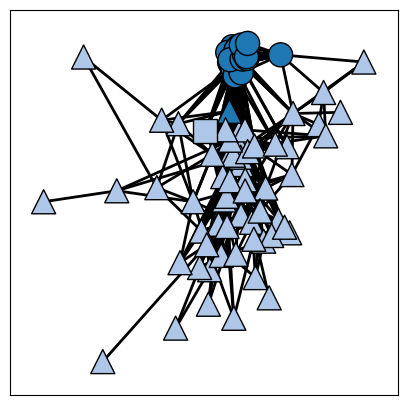

In [14]:
G = nx.Graph()

for i, elrow in df2.iterrows():
    G.add_edge(elrow[0], elrow[1], weight=elrow[4]) #, width=elrow[5]
    


clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(5,5))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')




for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)


shape_d = dict(zip(['-'.join([str(y) for y in x]) for x in list(hubs)], ['^']*len(hubs))) |\
dict(zip(list(organismal), ['o']*len(organismal))) | {'senescence': 's'}


for node in G.nodes(data=True):
    G.nodes(data=True)[node[0]]['s'] = shape_d[node[0]]
            
            

#Get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))

#For each node class...
for aShape in nodeShapes:
    nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))]
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    nx.draw_networkx_nodes(G,pos,node_shape = aShape,nodelist = nodelist,
                          node_color = [color_d[x[0]] for x in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],
                          edgecolors='k')
   
            
#widths = [G[u][v]['width'] for u,v in G.edges()]
            
# nx.draw_networkx_nodes(G, pos, 
#                        node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
#                        ) #edgecolors

nx.draw_networkx_edges(G, pos, width = 2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

#plt.savefig('for_poster/mouse_heart_myocyte_network.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [15]:
#this looks good but try signatures instead because hubs from the same cell do not have the same genes
#therefore will have 0 overlap

In [19]:
signatures

{('Bladder', 'bladder cell'): [('Rspo1', 33),
  ('Me3', 11),
  ('Clic3', 27),
  ('Slpi', 30),
  ('Cdh3', 37),
  ('Prlr', 28),
  ('Hoxc6', 27),
  ('Pcnxl2', 27),
  ('Wt1', 39),
  ('Dpp4', 50),
  ('Podxl', 33),
  ('Msln', 32),
  ('Sgcd', 20),
  ('Smpd3', 39),
  ('Nrxn2', 14),
  ('Slurp1', 29),
  ('Hoxc4', 17),
  ('Prr15l', 34),
  ('Bex1', 8),
  ('Syt7', 14),
  ('Espn', 28),
  ('Gpm6a', 35),
  ('Slc4a8', 26),
  ('Hoxd10', 21),
  ('Gpr64', 31),
  ('Ablim3', 29),
  ('Hoxd13', 10),
  ('Col8a2', 29),
  ('Map3k9', 4),
  ('Bicd1', 20),
  ('Kcnj8', 21),
  ('Myl7', 35),
  ('Cdon', 28),
  ('Pkhd1l1', 33),
  ('Fgf9', 18),
  ('Plscr2', 21),
  ('Matn4', 12),
  ('Rxrg', 21),
  ('Gfra3', 21),
  ('Kcna1', 23),
  ('Kcna2', 23),
  ('Cadm4', 27),
  ('Ppp1r14c', 6),
  ('Mpz', 21),
  ('Plce1', 30),
  ('Rasgef1c', 18),
  ('Cadm2', 32),
  ('Fam89a', 20),
  ('Ngfr', 9),
  ('Slc35f1', 19),
  ('Tmprss5', 17),
  ('Nat8l', 18),
  ('Lgi1', 19),
  ('Sfrp5', 22),
  ('Klk8', 18),
  ('Agtr1a', 32),
  ('Efhd1', 34),
  ('

In [25]:
import senepy as sp

sigs = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [28]:
sigs.merge_hubs(sigs.metadata, p_thres = 0.01, new_name = 'Universal') #adding universal senepy signature

In [30]:
signatures = sigs.hubs

In [31]:
out = []
for a,b in tqdm(list(itertools.combinations(list(signatures) + list(organismal), r = 2))):
    
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in signatures[a]]
  
    if '.' in b:
        bb = organismal[b]
    else:
        bb = [x[0] for x in signatures[b]]

    overlap = len([x for x in aa if x in bb])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(bb))
    
    
    if len(a) == 2:
        a = '-'.join([str(x) for x in a])
    if len(b) == 2:
        b = '-'.join([str(x) for x in b])
    
    out.append([a, b, p])
    
    
for a in tqdm(list(signatures) + list(organismal)):
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in signatures[a]]
  
    overlap = len([x for x in aa if x in list(markers)])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(markers))
    
    if len(a) == 2:
        a = '-'.join([str(x) for x in a])
    
    out.append([a, 'senescence', p])
    
df = pd.DataFrame(out, columns = ['a', 'b', 'p'])

df = df.sort_values('p').reset_index(drop = True)

df['FDR'] = df.p * len(df)

df['FDR'] = df['FDR'].replace(0, 4.9406564584124654e-324)

df['nlogFDR'] = -np.log10(df.FDR)

df

100%|████████████████████████████████████████| 120/120 [00:00<00:00, 369.23it/s]


,a,b,p,FDR,nlogFDR
0,GAT.myeloid cell,Heart.monocyte,0.0,4.940656e-324,323.306215
1,Mammary_Gland.basal cell,Skin.bulge keratinocyte,0.0,4.940656e-324,323.306215
2,Mammary_Gland.basal cell,Tongue.basal cell of epidermis,0.0,4.940656e-324,323.306215
3,Mammary_Gland.basal cell,Tongue.keratinocyte,0.0,4.940656e-324,323.306215
4,Brain_Non-Myeloid.oligodendrocyte,Skin.bulge keratinocyte,0.0,4.940656e-324,323.306215
...,...,...,...,...,...
7255,Large_Intestine-secretory cell,Mammary_Gland.luminal epithelial cell of mamma...,1.0,7.260000e+03,-3.860937
7256,Large_Intestine-secretory cell,Marrow.NK cell,1.0,7.260000e+03,-3.860937
7257,Large_Intestine-secretory cell,Marrow.granulocyte,1.0,7.260000e+03,-3.860937
7258,Large_Intestine-secretory cell,Marrow.hematopoietic stem cell,1.0,7.260000e+03,-3.860937


In [46]:
df3 = df[df.FDR <= 0.01].copy()
df3['width'] = (df2.nlogFDR/324)*25
df3['width'][df3['width'] > 15] = 15
df3

/tmp/ipykernel_3623831/1265393041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['width'][df3['width'] > 15] = 15


,a,b,p,FDR,nlogFDR,width
0,GAT.myeloid cell,Heart.monocyte,0.000000,4.940656e-324,323.306215,15.000000
1,Mammary_Gland.basal cell,Skin.bulge keratinocyte,0.000000,4.940656e-324,323.306215,15.000000
2,Mammary_Gland.basal cell,Tongue.basal cell of epidermis,0.000000,4.940656e-324,323.306215,15.000000
3,Mammary_Gland.basal cell,Tongue.keratinocyte,0.000000,4.940656e-324,323.306215,15.000000
4,Brain_Non-Myeloid.oligodendrocyte,Skin.bulge keratinocyte,0.000000,4.940656e-324,323.306215,15.000000
...,...,...,...,...,...,...
3193,Diaphragm-mesenchymal stem cell,Marrow.naive B cell,0.000001,8.809213e-03,2.055063,0.183334
3194,Kidney-Henle thick ascending limb epithelial cell,Liver-Kupffer cell,0.000001,8.993253e-03,2.046083,0.181510
3195,Liver-endothelial cell of hepatic sinusoid,BAT.myeloid cell,0.000001,9.084730e-03,2.041688,0.179539
3196,Tongue-basal cell,senescence,0.000001,9.736453e-03,2.011599,0.179478


### Fig 2E

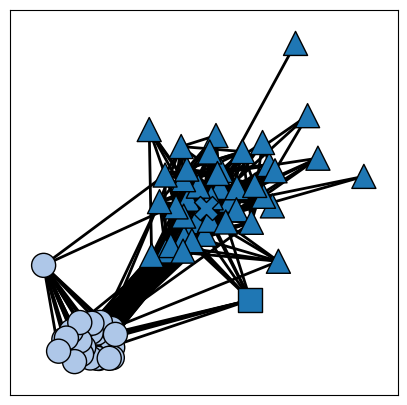

In [48]:
G = nx.Graph()

for i, elrow in df3.iterrows():
    G.add_edge(elrow[0], elrow[1], weight=elrow[4], width=elrow[5]) #, 
    


clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(5,5))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items()}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')




for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)


shape_d = dict(zip(['-'.join([str(y) for y in x]) for x in list(signatures)], ['^']*len(hubs))) |\
dict(zip(list(organismal), ['o']*len(organismal))) | {'senescence': 's'} | {'Universal': 'X'}


for node in G.nodes(data=True):
    G.nodes(data=True)[node[0]]['s'] = shape_d[node[0]]
            
            

#Get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))

#For each node class...
for aShape in nodeShapes:
    nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))]
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    nx.draw_networkx_nodes(G,pos,node_shape = aShape,nodelist = nodelist,
                          node_color = [color_d[x[0]] for x in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],
                          edgecolors='k')
   
            
widths = [G[u][v]['width'] for u,v in G.edges()]
            
# nx.draw_networkx_nodes(G, pos, 
#                        node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
#                        ) #edgecolors

nx.draw_networkx_edges(G, pos, width = 2) #width = widths

# texts = []
# txt = plt.text(x = node_lables['senescence'][0], y = node_lables['senescence'][1], s = 'SnC markers',
#                          fontsize = 11, weight = 'bold', ha = 'left', va = 'center')
# txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])


#texts.append(txt)

#adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

plt.savefig('figures/R1_2E.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_2E.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [51]:
df3[(df3.a.str.contains('senescence')) | (df3.b.str.contains('senescence'))]

,a,b,p,FDR,nlogFDR,width
2970,Heart_and_Aorta-endocardial cell,senescence,8.279602e-11,6.010991e-07,6.221054,0.511693
3044,Trachea-fibroblast,senescence,4.261672e-09,3.093974e-05,4.509483,0.377918
3083,GAT.mesenchymal stem cell of adipose,senescence,1.868490e-08,1.356524e-04,3.867573,0.330841
3093,Tongue-keratinocyte,senescence,3.216245e-08,2.334994e-04,3.631714,0.317743
3108,Bladder.bladder cell,senescence,7.490523e-08,5.438120e-04,3.264551,0.288480
3157,Liver.endothelial cell of hepatic sinusoid,senescence,4.981055e-07,3.616246e-03,2.441742,0.221971
3161,Liver-endothelial cell of hepatic sinusoid,senescence,5.826186e-07,4.229811e-03,2.373679,0.217551
3171,Universal,senescence,7.516670e-07,5.457102e-03,2.263038,0.207479
3182,Heart.fibroblast of cardiac tissue,senescence,9.454257e-07,6.863790e-03,2.163436,0.197449
3188,SCAT.myeloid cell,senescence,1.050035e-06,7.623251e-03,2.117860,0.188008


In [49]:
len(signatures)

44

In [14]:
#R1 R2 L165-166

In [23]:
df['as'] = df.a.map(shape_d)
df['bs'] = df.b.map(shape_d)

In [33]:
df[(df['as'] == '^') & (df.bs == '^') & (df.FDR< 0.05)]

,a,b,p,FDR,nlogFDR,as,bs
508,Diaphragm-mesenchymal stem cell-2,Diaphragm-skeletal muscle satellite cell-1,5.816735e-225,6.675285e-221,220.175530,^,^
803,Trachea-basal cell -1,Trachea-fibroblast-0,2.292711e-165,2.631115e-161,160.579860,^,^
926,Lung-fibroblast-1,Trachea-fibroblast-0,4.283217e-147,4.915420e-143,142.308439,^,^
977,Diaphragm-mesenchymal stem cell-2,Trachea-fibroblast-0,4.310744e-141,4.947010e-137,136.305657,^,^
1113,Diaphragm-skeletal muscle satellite cell-1,Trachea-fibroblast-0,2.122968e-128,2.436318e-124,123.613266,^,^
...,...,...,...,...,...,...,...
3257,Heart_and_Aorta-endocardial cell-1,Kidney-collecting duct principal cell-0,3.832851e-06,4.398580e-02,1.356688,^,^
3260,Heart_and_Aorta-fibroblast-1,Liver-Kupffer cell-1,4.012562e-06,4.604817e-02,1.336788,^,^
3261,Limb_Muscle-macrophage-0,Lymphoid-NK cell-2,4.146702e-06,4.758755e-02,1.322507,^,^
3262,HSC-hematopoietic stem cell-2,Lung-alveolar macrophage-2,4.184299e-06,4.801901e-02,1.318587,^,^


In [29]:
hub_metadata

,tissue,cell,hub_num,size,n_sen,hyp
0,Bladder,bladder cell,0,20,0,1.000000
1,Bladder,bladder cell,1,36,0,1.000000
2,Bladder,bladder cell,2,61,2,0.107390
3,Bladder,endothelial cell,1,29,0,1.000000
4,Diaphragm,mesenchymal stem cell,0,88,0,1.000000
...,...,...,...,...,...,...
70,Trachea,basal cell,1,495,16,0.000013
71,Trachea,fibroblast,0,680,21,0.000001
72,Trachea,fibroblast,1,74,2,0.147080
73,Trachea,macrophage,0,1654,23,0.028732


In [30]:
75*75

5625